In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\mindf\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#Load csv
NUTRITION_MYFITNESS_DATA = pd.read_excel(r'DATASETS\NUTRITION\NUTRITION_DATASET.xlsx')

In [3]:
NUTRITION_MYFITNESS_DATA.head

<bound method NDFrame.head of     CALORIES  CARBOHYDRATES  FAT  PROTEIN  SODIUM  SUGAR  SCORE
0       1423            172   61       56    2376     25      0
1       2001            343   49       57    2210    145      0
2       2001            223   92       67    2112    108      0
3       1827            256   62       65    2456    108      0
4       2001            250   56      125    2300     81      0
5       1355            167   56       44    1266     93      0
6       1000            149   27       39    2381     24      0
7       1772            288   60       57    1702     79      0
8       1975            335   51       60    2050    110      0
9       1800            368   60       59    3244    148      0
10      1185            132   59       48    1604     56      0
11      1879            191   80       62    1920     61      0
12       778            105   35       36     795     38      0
13      1036            164   34       23    2101     42      0
14       9

In [4]:
#Create dictionary of ideal values for each score; calculate L2 norm to generate score)
IDEAL_VALS = {'CALORIES': 2250, 'CARBOHYDRATES': 275, 'FAT': 61, 'PROTEIN': 112.5,
              'SODIUM': 2300, 'SUGAR': 125}
columns = NUTRITION_MYFITNESS_DATA.columns.values.tolist()
columns = columns[:6]
#Generate scores for each lever - compare iteratively and generate average score on its basis
def generate_score(row):
    #Iterate over each column except for gender
    print(" =================================== ")
    total_score = 0
    for column in columns:
        if column == "SCORE": continue
        print(row[column], IDEAL_VALS[column])
        column_score = abs(row[column] - IDEAL_VALS[column])
        print(column_score)
        total_score += column_score
    #Average out the score
    row["SCORE"] = total_score / len(columns)
    print('END SCORE: ', row["SCORE"])
    return row

NUTRITION_MYFITNESS_DATA = NUTRITION_MYFITNESS_DATA.apply(generate_score, axis = "columns")

1423 2250
827
172 275
103
61 61
0
56 112.5
56.5
2376 2300
76
25 125
100
END SCORE:  193.75
2001 2250
249
343 275
68
49 61
12
57 112.5
55.5
2210 2300
90
145 125
20
END SCORE:  82.41666666666667
2001 2250
249
223 275
52
92 61
31
67 112.5
45.5
2112 2300
188
108 125
17
END SCORE:  97.08333333333333
1827 2250
423
256 275
19
62 61
1
65 112.5
47.5
2456 2300
156
108 125
17
END SCORE:  110.58333333333333
2001 2250
249
250 275
25
56 61
5
125 112.5
12.5
2300 2300
0
81 125
44
END SCORE:  55.916666666666664
1355 2250
895
167 275
108
56 61
5
44 112.5
68.5
1266 2300
1034
93 125
32
END SCORE:  357.0833333333333
1000 2250
1250
149 275
126
27 61
34
39 112.5
73.5
2381 2300
81
24 125
101
END SCORE:  277.5833333333333
1772 2250
478
288 275
13
60 61
1
57 112.5
55.5
1702 2300
598
79 125
46
END SCORE:  198.58333333333334
1975 2250
275
335 275
60
51 61
10
60 112.5
52.5
2050 2300
250
110 125
15
END SCORE:  110.41666666666667
1800 2250
450
368 275
93
60 61
1
59 112.5
53.5
3244 2300
944
148 125
23
END SCORE:  260

In [5]:
print(NUTRITION_MYFITNESS_DATA)

    CALORIES  CARBOHYDRATES   FAT  PROTEIN  SODIUM  SUGAR       SCORE
0     1423.0          172.0  61.0     56.0  2376.0   25.0  193.750000
1     2001.0          343.0  49.0     57.0  2210.0  145.0   82.416667
2     2001.0          223.0  92.0     67.0  2112.0  108.0   97.083333
3     1827.0          256.0  62.0     65.0  2456.0  108.0  110.583333
4     2001.0          250.0  56.0    125.0  2300.0   81.0   55.916667
5     1355.0          167.0  56.0     44.0  1266.0   93.0  357.083333
6     1000.0          149.0  27.0     39.0  2381.0   24.0  277.583333
7     1772.0          288.0  60.0     57.0  1702.0   79.0  198.583333
8     1975.0          335.0  51.0     60.0  2050.0  110.0  110.416667
9     1800.0          368.0  60.0     59.0  3244.0  148.0  260.750000
10    1185.0          132.0  59.0     48.0  1604.0   56.0  339.916667
11    1879.0          191.0  80.0     62.0  1920.0   61.0  161.416667
12     778.0          105.0  35.0     36.0   795.0   38.0  556.083333
13    1036.0        

In [6]:
print(NUTRITION_MYFITNESS_DATA.head)
NUTRITION_MYFITNESS_DATA.to_pickle('PREPROCESSED_NUTRITION_MYFITNESS_DATA.pkl')

<bound method NDFrame.head of     CALORIES  CARBOHYDRATES   FAT  PROTEIN  SODIUM  SUGAR       SCORE
0     1423.0          172.0  61.0     56.0  2376.0   25.0  193.750000
1     2001.0          343.0  49.0     57.0  2210.0  145.0   82.416667
2     2001.0          223.0  92.0     67.0  2112.0  108.0   97.083333
3     1827.0          256.0  62.0     65.0  2456.0  108.0  110.583333
4     2001.0          250.0  56.0    125.0  2300.0   81.0   55.916667
5     1355.0          167.0  56.0     44.0  1266.0   93.0  357.083333
6     1000.0          149.0  27.0     39.0  2381.0   24.0  277.583333
7     1772.0          288.0  60.0     57.0  1702.0   79.0  198.583333
8     1975.0          335.0  51.0     60.0  2050.0  110.0  110.416667
9     1800.0          368.0  60.0     59.0  3244.0  148.0  260.750000
10    1185.0          132.0  59.0     48.0  1604.0   56.0  339.916667
11    1879.0          191.0  80.0     62.0  1920.0   61.0  161.416667
12     778.0          105.0  35.0     36.0   795.0   38.0  5

In [7]:
#Reshape tensors for XGBOOST
import tensorflow as tf
from sklearn.model_selection import train_test_split

x_features = NUTRITION_MYFITNESS_DATA.iloc[:, :6]
print(x_features)
y_labels = NUTRITION_MYFITNESS_DATA["SCORE"]
train_x, valid_x, train_y, valid_y = train_test_split(x_features, y_labels, random_state = 2, shuffle = True)

train_x = tf.convert_to_tensor(train_x)
train_x = tf.reshape(train_x, [len(train_x), 6])

valid_x = tf.convert_to_tensor(valid_x)
valid_x = tf.reshape(valid_x, [len(valid_x), 6])

train_y = tf.convert_to_tensor(train_y)
train_y = tf.reshape(train_y, [len(train_y), 1])

valid_y = tf.convert_to_tensor(valid_y)
valid_y = tf.reshape(valid_y, [len(valid_y), 1])

    CALORIES  CARBOHYDRATES   FAT  PROTEIN  SODIUM  SUGAR
0     1423.0          172.0  61.0     56.0  2376.0   25.0
1     2001.0          343.0  49.0     57.0  2210.0  145.0
2     2001.0          223.0  92.0     67.0  2112.0  108.0
3     1827.0          256.0  62.0     65.0  2456.0  108.0
4     2001.0          250.0  56.0    125.0  2300.0   81.0
5     1355.0          167.0  56.0     44.0  1266.0   93.0
6     1000.0          149.0  27.0     39.0  2381.0   24.0
7     1772.0          288.0  60.0     57.0  1702.0   79.0
8     1975.0          335.0  51.0     60.0  2050.0  110.0
9     1800.0          368.0  60.0     59.0  3244.0  148.0
10    1185.0          132.0  59.0     48.0  1604.0   56.0
11    1879.0          191.0  80.0     62.0  1920.0   61.0
12     778.0          105.0  35.0     36.0   795.0   38.0
13    1036.0          164.0  34.0     23.0  2101.0   42.0
14     998.0          178.0  14.0     54.0   787.0   43.0
15    1271.0          179.0  30.0     69.0  2291.0   25.0
16    1575.0  

In [8]:
#TRAIN GRADIENT BOOSTED TREE
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Convert to Dmatrix
TRAIN_DATA = xgb.DMatrix(train_x, train_y, feature_names = columns[:6])
VALID_DATA = xgb.DMatrix(valid_x, valid_y, feature_names = columns[:6])
#Parameters for boosted tree
XGBOOST_PARAMS = {"objective": "reg:squarederror", "subsample": 0.6,
                  "colsample_bytree" : 0.6, "learning_rate" : 0.1, "max_depth" : 100,
                  "alpha": 20, "n_estimators": 12}
#Train the xgboost model
XGB_NUTRITION_MODEL = xgb.train(XGBOOST_PARAMS, TRAIN_DATA, evals = [(TRAIN_DATA, "TRAIN_DATA"), (VALID_DATA, "VALID_DATA")],
                            num_boost_round = 200, early_stopping_rounds = 40)
predictions = XGB_NUTRITION_MODEL.predict(VALID_DATA)
error = mean_absolute_error(valid_y, predictions)
print('ERROR: ', error)

[17:52:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	TRAIN_DATA-rmse:297.20090	VALID_DATA-rmse:202.51248
[1]	TRAIN_DATA-rmse:283.40820	VALID_DATA-rmse:187.21147
[2]	TRAIN_DATA-rmse:265.71304	VALID_DATA-rmse:172.67262
[3]	TRAIN_DATA-rmse:246.44974	VALID_DATA-rmse:160.54864
[4]	TRAIN_DATA-rmse:227.82654	VALID_DATA-rmse:152.33933
[5]	TRAIN_DATA-rmse:210.52936	VALID_DATA-rmse:145.16296
[6]	TRAIN_DATA-rmse:196.65736	VALID_DATA-rmse:134.63860
[7]	TRAIN_DATA-rmse:184.08818	VALID_DATA-rmse:125.31136
[8]	TRAIN_DATA-rmse:179.93411	VALID_DATA-rmse:121.27068
[9]	TRAIN_DATA-rmse:174.71794	VALID_DATA-rmse:113.86499
[1

In [18]:
#Save Model
XGB_NUTRITION_MODEL.save_model('METRICS_NUTRITION_GRADBOOSTED_MODELS[63.24].model')

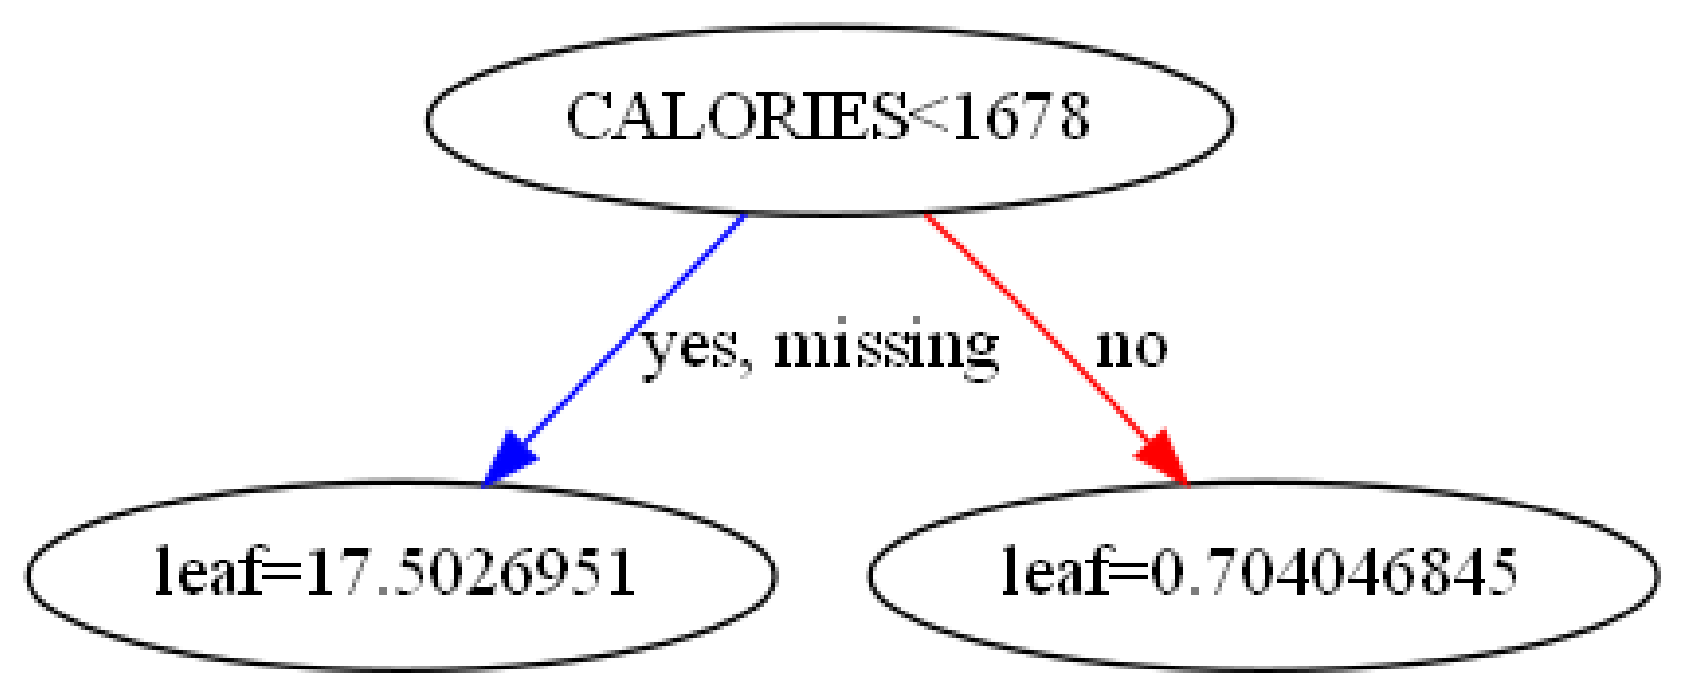

In [9]:
#Print desicion tree -> transparency into exactly what the model is doing
ig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(XGB_NUTRITION_MODEL, num_trees=10, ax=ax)
plt.show()